In [1]:
"""
https://www.kaggle.com/c/dogs-vs-cats/overview
"""
import os
import shutil
from pathlib import Path

iskaggle = os.getenv("KAGGLE_KERNEL_RUN_TYPE")

# If on kaggle, install packages
if iskaggle:
    os.system("pip install fastai loguru")

from fastai.callback.schedule import fine_tune
from fastai.data.block import CategoryBlock, DataBlock
from fastai.data.external import URLs, untar_data
from fastai.data.transforms import GrandparentSplitter, RandomSplitter, get_image_files
from fastai.learner import Learner, export, load_learner
from fastai.metrics import F1Score, accuracy, error_rate
from fastai.vision.all import parent_label
from fastai.vision.augment import Resize
from fastai.vision.core import PILImage
from fastai.vision.data import ImageBlock
from fastai.vision.learner import vision_learner
from fastai.vision.models import resnet34
from loguru import logger

url = URLs.DOGS
# Download and unpack dataset
path = untar_data(url)

model_file = Path("model.pkl")
path

Path('/home/burny/.fastai/data/dogscats')

In [16]:
# Define how to load image
def get_x(image_path: str) -> PILImage:
    return PILImage.create(image_path)


# Define label function
def get_y(image_file_path: Path) -> str:
    return image_file_path.name[:3]


def get_only_train_valid_items(my_path: Path) -> list[Path]:
    # Only get images that have "train" and "valid" in the name

    # Required for RandomSplitter
    # return get_image_files(my_path, folders=["train", "valid"])

    # Works with GrandparentSplitter
    return get_image_files(my_path)

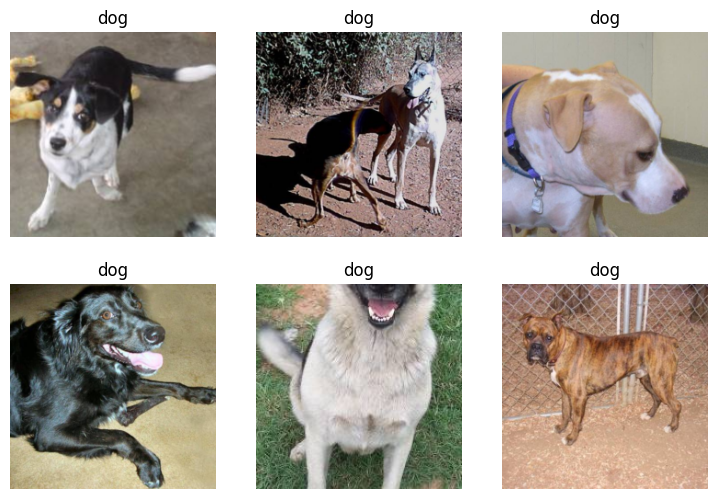

In [17]:
# Create a DataBlock for image data
dblock = DataBlock(
    # Optionally set the categories via vocab=[]
    # blocks=(ImageBlock, CategoryBlock),
    blocks=(ImageBlock, CategoryBlock(vocab=["cat", "dog"])),
    get_items=get_only_train_valid_items,
    get_x=get_x,
    # get_y=parent_label,
    get_y=get_y,
    splitter=GrandparentSplitter(train_name="train", valid_name="valid"),
    # splitter=RandomSplitter(valid_pct=0.2, seed=42),
    item_tfms=Resize(224),
)

# Define data loader
dls = dblock.dataloaders(path)
# dls = dblock.dataloaders(path, bs=64)

# Display examples
dls.show_batch(max_n=6)
# dls.show_batch(max_n=6, figsize=(14, 14))

In [18]:
# List all gathered categories
dls.vocab

['cat', 'dog']

In [8]:
# Load model if already trained
learn = None
if model_file.is_file():
    # model_file.unlink()
    logger.info("Model exists, load model")
    learn = load_learner(model_file)

# Train model if it doesn't exist
if learn is None:
    logger.info("Model does not exist, train model")

    learn = vision_learner(dls, resnet34, metrics=error_rate)
    learn.fine_tune(1)

    logger.info("Done training model")
    # learn.save() and load_model() are only for checkpoints in the training process
    learn.export("model.pkl")
    if Path("/kaggle/working/model.pkl") != model_file:
        shutil.copy("/kaggle/working/model.pkl", model_file)

# If on kaggle, provide download link to model
if iskaggle:
    logger.info("Provide model download link")
    from IPython.display import FileLink

    FileLink(model_file)

2024-01-03 02:27:54.461 | INFO     | __main__:<module>:5 - Model exists, load model


AttributeError: Custom classes or functions exported with your `Learner` not available in namespace.\Re-declare/import before loading:
	Can't get attribute 'is_cat' on <module '__main__'>

2023-12-27 02:35:24.920 | INFO     | __main__:<module>:2 - Predict an image


2023-12-27 02:35:25.017 | INFO     | __main__:<module>:5 - Result for image /home/burny/.fastai/data/dogscats/test1/3571.jpg is: ('False', tensor(0), tensor([0.9979, 0.0021]))


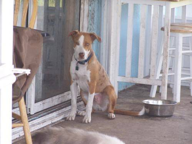

In [8]:
# Predict result from a test image
logger.info("Predict an image")
image = get_image_files(path / "test1")[2]
result = learn.predict(image)
logger.info(f"Result for image {image} is: {result}")
# Show a preview of the image on notebook
PILImage.create(image).to_thumb(192)